# Projekt Końcowy Kodilla Kurs ML

### Problemem do rozwiązania jest klasyfikacja, czy przyznać kartę kredytową.

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:
    - X6 = the repayment status in September, 2005;
    - X7 = the repayment status in August, 2005;
    - . . .;
    - X11 = the repayment status in April, 2005.
    
    The measurement scale for the repayment status is:
    
    - -1 = pay duly;
    - 1 = payment delay for one month;
    - 2 = payment delay for two months;
    - . . .;
    - 8 = payment delay for eight months;
    - 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar).
    - X12 = amount of bill statement in September, 2005;
    - X13 = amount of bill statement in August, 2005;
    - . . .;
    - X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar).
    - X18 = amount paid in September, 2005;
    - X19 = amount paid in August, 2005;
    - . . .;
    - X23 = amount paid in April, 2005.

In [ ]:
# data manipulation
import numpy as np
import pandas as pd

### from tqdm import tqdm

# data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, ScalarFormatter
import seaborn as sns

# feature selection
from sklearn.feature_selection import RFECV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.linear_model import LinearRegression

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from scipy.stats import chi2_contingency

# interpretowalność modelu
import shap
shap.initjs()

# zapisanie modelu
import joblib

### 1. Zrozumienie uwarunkowań biznesowych
Dataset zawiera informacje o klientach Tajwańskiego Banku, w tym podstawowe dane demograficzne (`X2–X5`), wysokość przyznanego kredytu (`X1`), historię terminowości spłat (`X6–X11`), informacje o wysokościach rachunków (`X12–X17`) i kwotach spłaconych w ostatnich miesiącach (`X18–X23`).
Zmienna docelowa `Y` informuje, czy klient zalega ze spłatą (1) czy nie (0). Można ją zinterpretować jako ocenę ryzyka; jeśli Y=1, to znaczy, że klient faktycznie stał się niewypłacalny. Model ma więc przewidzieć wartość `Y` i pomóc zdecydować, czy bezpiecznie jest przyznać kartę kredytową.

Ryzyko błędów:

 - False Positive (Y=1 predykcja, faktycznie Y=0): Bank rezygnuje z dobrego klienta.
 - False Negative (Y=0 predykcja, faktycznie Y=1): Bank przyznaje kartę klientowi, który nie spłaci.

Biorąc pod uwagę, że koszty FN zazwyczaj są większe (bezpośrednia strata), a FP oznacza utracenie potencjalnie dobrego klienta, dążymy do osiągnięcia wysokiego F1-Score (zrównoważenie precision i recall) oraz wysokiego AUC-ROC. Dodatkowo kontrolujemy, by czułość (Recall) nie była zbyt niska, bo przeoczenie złego klienta bywa najbardziej kosztowne.

### 2. Wstępna Analiza danych i przygotowanie datasetu

In [2]:
df = pd.read_excel('default_of_credit_card_clients.xls', header=1)
df = df.rename(columns={'default payment next month': 'DEFAULT'})
df = df.rename(columns={'PAY_0': 'PAY_1'})
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df = df.drop('ID', axis=1)

display(df.head())
display(df.tail())
df.info()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1
29999,50000,1,2,1,46,0,0,0,0,0,...,36535,32428,15313,2078,1800,1430,1000,1000,1000,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

W celu ujednolicenia nazewnictwa zmieniłem `PAY_0` na `PAY_1` oraz zmieniłem `default payment next month` na `DEFAULT`. Pozbyłem się też kolumny `ID`, ponieważ jest tylko powieleniem indexu. 

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


In [4]:
df.duplicated().any() == False

False

Początkowe wnioski po wstępnej analizie danych:
- nie ma braków danych
- w dataset są duplikaty
- zmienne są w formie liczbowej, a niektóre z nich to zmienne kategoryczne
- w BILL_AMT* występują wartości ujemne, a także wartości odstające
- w PAY_*, MARRIAGE, EDUCATION występują wartości niezgodne z dokumentacją
- zmienne są w różnej skali
- zmienna objaśniana DEFAULT jest niezbalansowana

Ponieważ całkowita zgodność wszystkich wartości w dwóch wierszach jest w praktyce mało prawdopodobna (błąd bazy/duplikacja wpisu), uznaję je za powtórzenia i usuwam, by nie zafałszować dalszej analizy.

In [5]:
df = df.drop_duplicates()

Przyjrzyjmy się wartości -2 w polach `PAY_*`

In [6]:
pay_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_cols:
    count_neg2 = (df[col] == -2).sum()
    print(f"{col} ma {count_neg2} wpisów o wartości -2")

PAY_1 ma 2750 wpisów o wartości -2
PAY_2 ma 3752 wpisów o wartości -2
PAY_3 ma 4055 wpisów o wartości -2
PAY_4 ma 4318 wpisów o wartości -2
PAY_5 ma 4516 wpisów o wartości -2
PAY_6 ma 4865 wpisów o wartości -2


In [7]:
df['neg2_count'] = (df[pay_cols] == -2).sum(axis=1)

group = df.groupby(['neg2_count', 'DEFAULT']).size().reset_index(name='count')

pivot_table = group.pivot(index='neg2_count', columns='DEFAULT', values='count').fillna(0)
pivot_table.columns = ['No Default (0)', 'Default (1)']

pivot_table['Total'] = pivot_table.sum(axis=1)

pivot_table['No Default (0) %'] = round((pivot_table['No Default (0)'] / pivot_table['Total']) * 100, 2)
pivot_table['Default (1) %']    = round((pivot_table['Default (1)']    / pivot_table['Total']) * 100, 2)

pivot_table

,No Default (0),Default (1),Total,No Default (0) %,Default (1) %
neg2_count,,,,,
0,18050,5384,23434,77.02,22.98
1,1102,264,1366,80.67,19.33
2,766,173,939,81.58,18.42
3,651,159,810,80.37,19.63
4,478,120,598,79.93,20.07
5,471,247,718,65.60,34.40
6,1817,283,2100,86.52,13.48


Nie widać wzorca zachowań w przypadku wartości -2 dla wierszy gdzie ta wartość powtarza się od 0 do 4 razy. Widać wyraźne odstępstwa od normy przy 5 i 6 powtórzeniach. Do dalszej analizy tego zagadnienia wyszukałem informacje na Kaggle co mogą oznaczać te nieujęte w wyjaśnieniach wartości:

"-2 = brak transakcji (więc i brak kwoty do spłaty),
-1 = zapłacone w całości (w terminie/bez zadłużenia),
0 = użycie kredytu odnawialnego (spłata minimalna lub częściowa, saldo przeniesione)."

Informacje zostały znalezione na Kaggle i cytują twórcę datasetu, więc są miarodajne. Możemy więc pozostawić te zmienne ponieważ wpisują się w skalę (nim mniejszy wynik tym lepiej).

Przy inżynierii cech można przemyśleć tego typu agregację cech, aby dostarczyć informację do modelu.

In [8]:
df = df.drop('neg2_count', axis=1)

In [9]:
df['MARRIAGE'].value_counts()

MARRIAGE
2    15945
1    13643
3      323
0       54
Name: count, dtype: int64

In [10]:
# Procent defaultu w zależności od MARRIAGE
marriage_default = df.groupby('MARRIAGE')['DEFAULT'].mean() * 100
print(marriage_default)

MARRIAGE
0     9.259259
1    23.462582
2    20.947005
3    26.006192
Name: DEFAULT, dtype: float64


In [11]:
df['EDUCATION'].value_counts()

EDUCATION
2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: count, dtype: int64

In [12]:
# Procent defaultu w zależności od EDUCATION
education_default = df.groupby('EDUCATION')['DEFAULT'].mean() * 100
print(education_default)

EDUCATION
0     0.000000
1    19.236959
2    23.739211
3    25.167854
4     5.691057
5     6.428571
6    15.686275
Name: DEFAULT, dtype: float64


Mimo że wartości 0, 5 i 6 w `EDUCATION` są procentowo rozbierzne od typowego `DEFAULTU` to jest jest to mała liczba obserwacji, więc włączymy je do kategorii "Others".

Tak samo postąpimy z wartością 0 w `MARRIAGE`. Tak mała liczba obserwacji nie wpłynie znacząco na wyniki.

In [13]:
# MARRIAGE: scal 0 z 3
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

# EDUCATION: scal 0, 5, 6 z 4
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})

### 3. Wizualna Eksploracja Danych

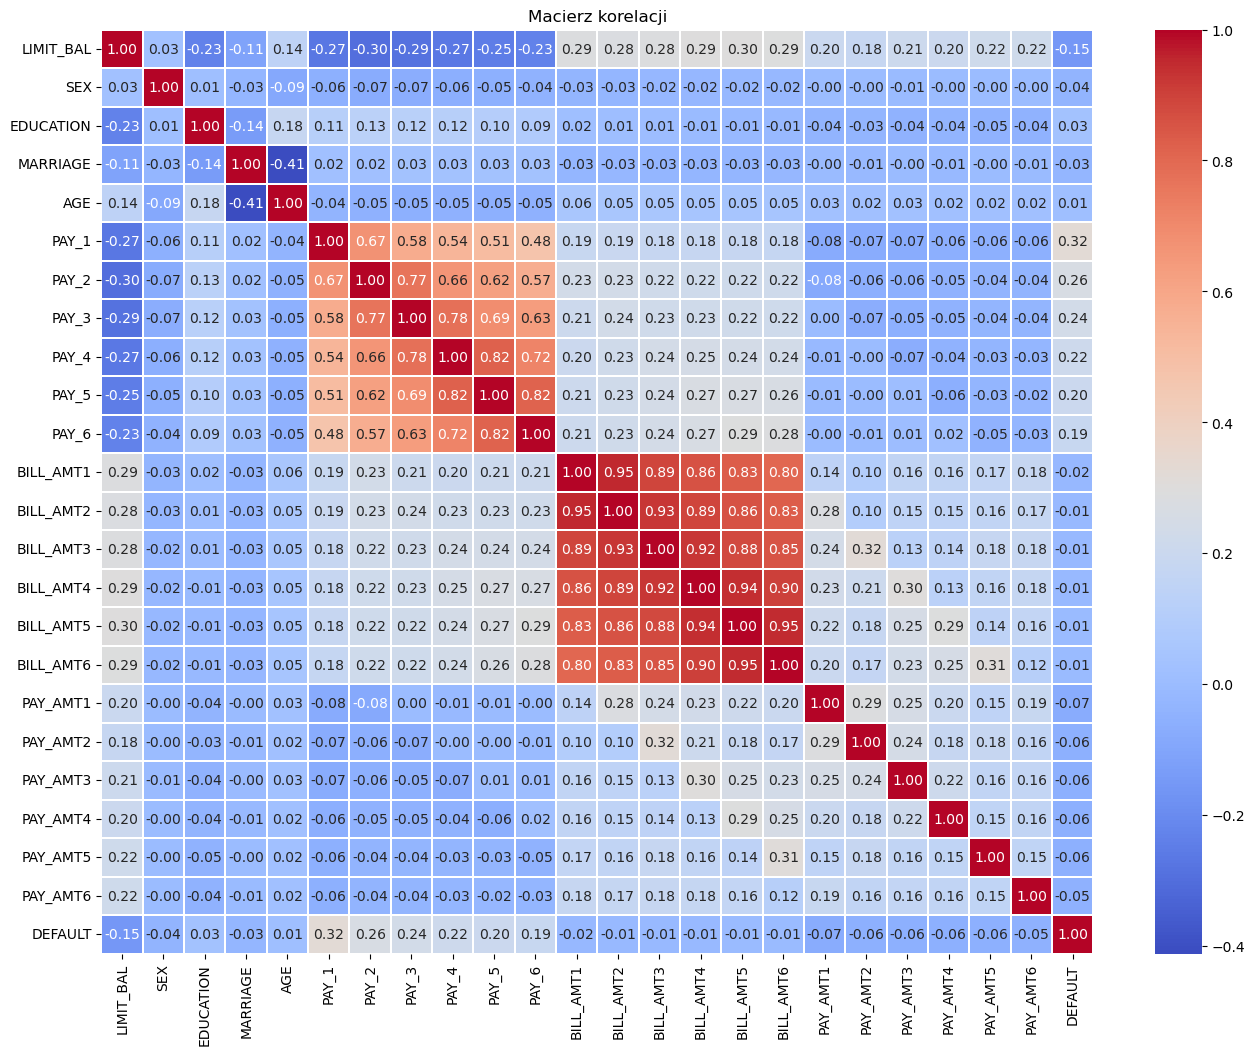

In [14]:
corr = df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, linewidths=0.23)
plt.title('Macierz korelacji')
plt.show()

Podsumowanie dotychczasowej analizy korelacji:

Z macierzy korelacji wynika, że żadna pojedyncza zmienna nie jest silnie skorelowana liniowo z DEFAULT. Najwyższą (choć wciąż relatywnie niską) korelację z `DEFAULT` ma `LIMIT_BAL` (ok. -0.15). Zaobserwowano też silne powiązania między kolumnami `PAY_*`, co jest logiczne – status opóźnienia z jednego miesiąca często koreluje z opóźnieniem w kolejnych. Podobną zależność widać wśród `BILL_AMT*` i `PAY_AMT*`.

Zmienne kategoryczne (`SEX`, `EDUCATION`, `MARRIAGE`) z natury nie ujawnią wysokiej korelacji liniowej w macierzy, więc na tym etapie nie widać wyraźnego wpływu na `DEFAULT`. Dopiero dalsza analiza (np. wykresy słupkowe) pozwoli sprawdzić, czy któraś z nich istotnie różnicuje klientów.

Brak mocnego związku z `DEFAULT` nie musi oznaczać, że cechy są nieprzydatne; relacja z `DEFAULT` może być nieliniowa lub ujawniać się dopiero w kombinacjach zmiennych. W kolejnych krokach warto więc przyjrzeć się rozkładom (np. boxplotom z rozbiciem na `DEFAULT`), a także wykorzystać model drzewiasty (np. RandomForest) i ocenić „feature importance”.

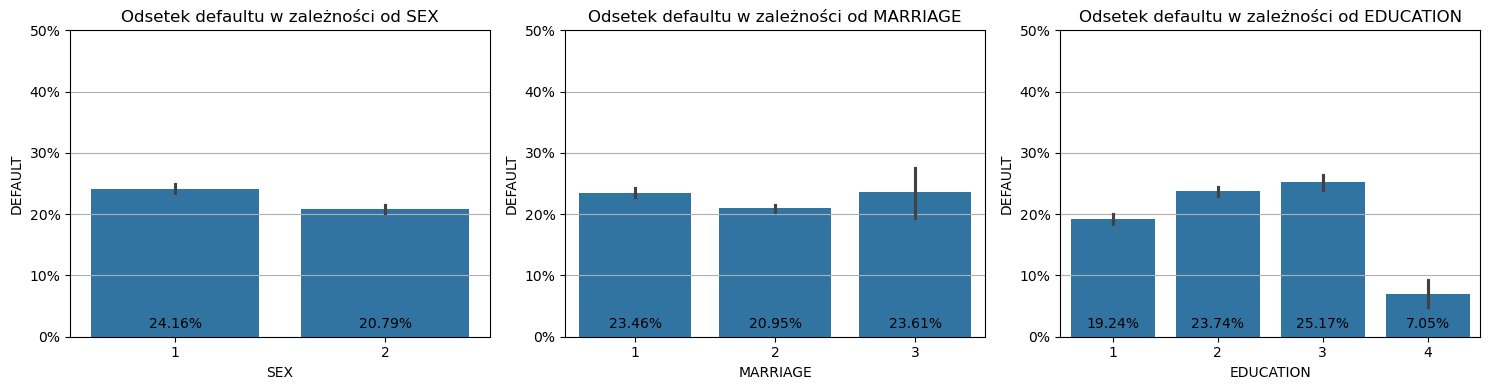

In [15]:
categorical_vars = ["SEX", "MARRIAGE", "EDUCATION"]

fig, axes = plt.subplots(nrows=1, ncols=len(categorical_vars), figsize=(15, 4))

for i, cat in enumerate(categorical_vars):
    ax = axes[i]
    sns.barplot(
        x=cat, 
        y="DEFAULT", 
        data=df, 
        ax=ax, 
        estimator=lambda x: sum(x)/len(x)  # udział defaultu
    )
    ax.set_title(f"Odsetek defaultu w zależności od {cat}")

    # Dodaj etykiety procentowe nad słupkami
    for p in ax.patches:
        height = p.get_height()
        x_pos = p.get_x() + p.get_width() / 2
        y_pos = 0.02
        label = f"{height*100:.2f}%"
        ax.annotate(
            label, 
            (x_pos, y_pos),
            ha="center", va="center",
            fontsize=10, color="black",
        )

    ax.set_ylim(0, 0.5)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.grid(True, axis="y")

plt.tight_layout()
plt.show()

In [16]:


for cat in categorical_vars:
    # Tabela krzyżowa: wiersze = kategorie cat, kolumny = 0/1 z DEFAULT
    contingency_table = pd.crosstab(df[cat], df["DEFAULT"])
    
    # Obliczenie statystyki chi2, p-value, liczby stopni swobody (dof) oraz oczekiwanych liczebności
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Test chi-kwadrat dla {cat}:")
    print(f"  chi2 = {chi2:.3f}, p-value = {p:.5f}, dof = {dof}")
    print("  Tabela krzyżowa:\n", contingency_table, "\n")

Test chi-kwadrat dla SEX:
  chi2 = 47.131, p-value = 0.00000, dof = 1
  Tabela krzyżowa:
 DEFAULT      0     1
SEX                 
1         9005  2869
2        14330  3761 

Test chi-kwadrat dla MARRIAGE:
  chi2 = 27.489, p-value = 0.00000, dof = 2
  Tabela krzyżowa:
 DEFAULT       0     1
MARRIAGE             
1         10442  3201
2         12605  3340
3           288    89 

Test chi-kwadrat dla EDUCATION:
  chi2 = 160.460, p-value = 0.00000, dof = 3
  Tabela krzyżowa:
 DEFAULT        0     1
EDUCATION             
1           8531  2032
2          10691  3328
3           3678  1237
4            435    33 



Wyniki testu chi-kwadrat dla każdej ze zmiennych kategorycznych (p-value < 0,00001) wskazują na istotny statystycznie związek z ryzykiem braku spłaty zadłużenia.

Z wykresów słupkowych przedstawiających odsetek defaultu widać, że:

- Płeć: mężczyźni (1) nieznacznie częściej nie spłacają zobowiązań (~24%) niż kobiety (2) (~21%).

- Stan cywilny: osoby w małżeństwie (1) i single (2) mają podobną choć odrobinę mniejszą zależność (~23% i ~21%), natomiast grupa „inne” (3) charakteryzuje się odrobinę wyższym odsetkiem (~24%).

- Wykształcenie: najniższy udział defaultu (~7%) ma kategoria „inne” (4), natomiast w pozostałych (1–3) waha się on między 19% a 25%.

Różnice te są statystycznie istotne, choć same nie przesądza jeszcze o sile wpływu na wagę obserwacji. Wyniki sugerują, że płeć, stan cywilny oraz wykształcenie mogą być pomocne w przewidywaniu `DEFAULT`, warto więc uwzględnić je jako cechy wejściowe w dalszym modelowaniu.

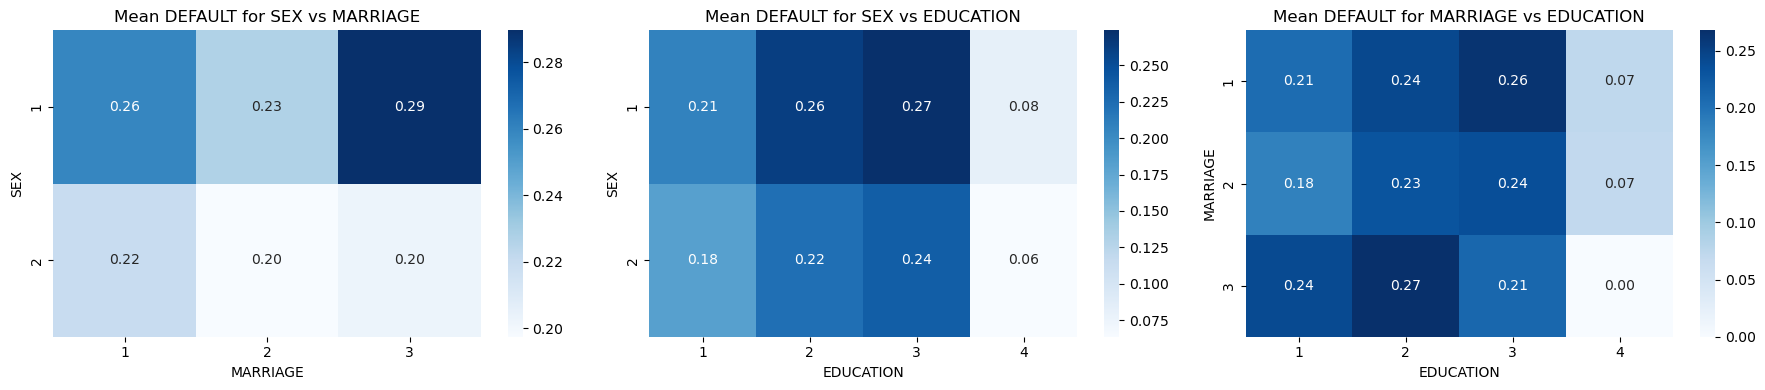

In [17]:
pairs = [
    ("SEX", "MARRIAGE"),
    ("SEX", "EDUCATION"),
    ("MARRIAGE", "EDUCATION"),
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

for ax, (cat1, cat2) in zip(axes.flatten(), pairs):
    crosstab_data = pd.crosstab(
        df[cat1],
        df[cat2],
        values=df["DEFAULT"],
        aggfunc="mean"
    )

    sns.heatmap(
        crosstab_data,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"Mean DEFAULT for {cat1} vs {cat2}")

plt.tight_layout()
plt.show()

Żonaci mężczyźni oraz o statusie matrymonialnym nieznanym, częściej stają się niewypłacalni. Kobiety za to utrzymują się lub są lekko poniżej średniej, wyniki są bardziej stabilne. W porównaniu z wykształceniem to nim wyższe tym mniejszy odsetek ludzi mających predyspozycję do zadłużenia. Wykształcone kobiety mają najniższe ryzyko bycia zadłużonym (spada do 18%), a nim mniejsze wykształcenie u mężczyzn tym większe ryzyko zadłużenia (rośnie do 27%). Podobnie sytuacja wygląda przypadku porównania wykształcenia i statusu matrymonialnego. Osobym po ślubie częściej okazują się dłużnikami (26% dla osób z wykształceniem średnim), ale nim wyższe wykształcenie tym bardziej ta szansa maleje ( do 0.18 dla osób bez ślubu i wyższym wykształceniem). Wyniki dla osób o nienznanym statusie matrymonialnym i wykształceniu spoza trzech głównych kategorii mogą być niemiarodajne z uwagi na małą liczbę danych.

In [18]:

pay_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

def boxplot_pay_vars(df, cols, target):
    fig, axes = plt.subplots(nrows=2, ncols=int(len(cols)/2), figsize=(14, 8))
    axes = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.boxplot(x=target, y=col, data=df, ax=ax)
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel(col)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [19]:
def count_pay_vars(df, cols, target):
    fig, axes = plt.subplots(nrows=2, ncols=int(len(cols)/2), figsize=(14, 8))
    axes = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.countplot(x=col, data=df, hue=target, ax=ax)
        ax.set_title(f"Liczebność kategorii w {col}, z rozbiciem na {target}")
        ax.grid(axis="y")
    
    plt.tight_layout()
    plt.show()

In [20]:
def stacked_bar_for_paycols(df, cols, target='DEFAULT'):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
    axes = axes.ravel()  # spłaszczamy tablicę [2,3] do [6]

    for i, col in enumerate(cols):
        ax = axes[i]

        df_group = (df.groupby([col, target]).size().reset_index(name='count'))
        df_group['total_for_cat'] = (df_group.groupby(col)['count'].transform('sum'))
        df_group['percentage'] = (df_group['count'] / df_group['total_for_cat'] * 100)

        pivoted = df_group.pivot(index=col, columns=target, values='percentage').fillna(0)
        pivoted = pivoted.sort_index()

        x_vals = np.arange(len(pivoted.index))
        vals_not_default = pivoted.get(0, 0)
        vals_default = pivoted.get(1, 0)

        ax.bar(
            x_vals,
            vals_not_default,
            label='No default(%)',
            color='steelblue')
        ax.bar(
            x_vals,
            vals_default,
            bottom=vals_not_default,
            label='Default(%)',
            color='darkorange')

        ax.set_title(f"{col} % defaultu")
        ax.set_xlabel(col)
        ax.set_ylabel('Odsetek (%)')
        ax.set_xticks(x_vals)
        ax.set_xticklabels(pivoted.index, rotation=45)
        ax.set_ylim(0, 100)
        ax.grid(axis='y')

        if i == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()

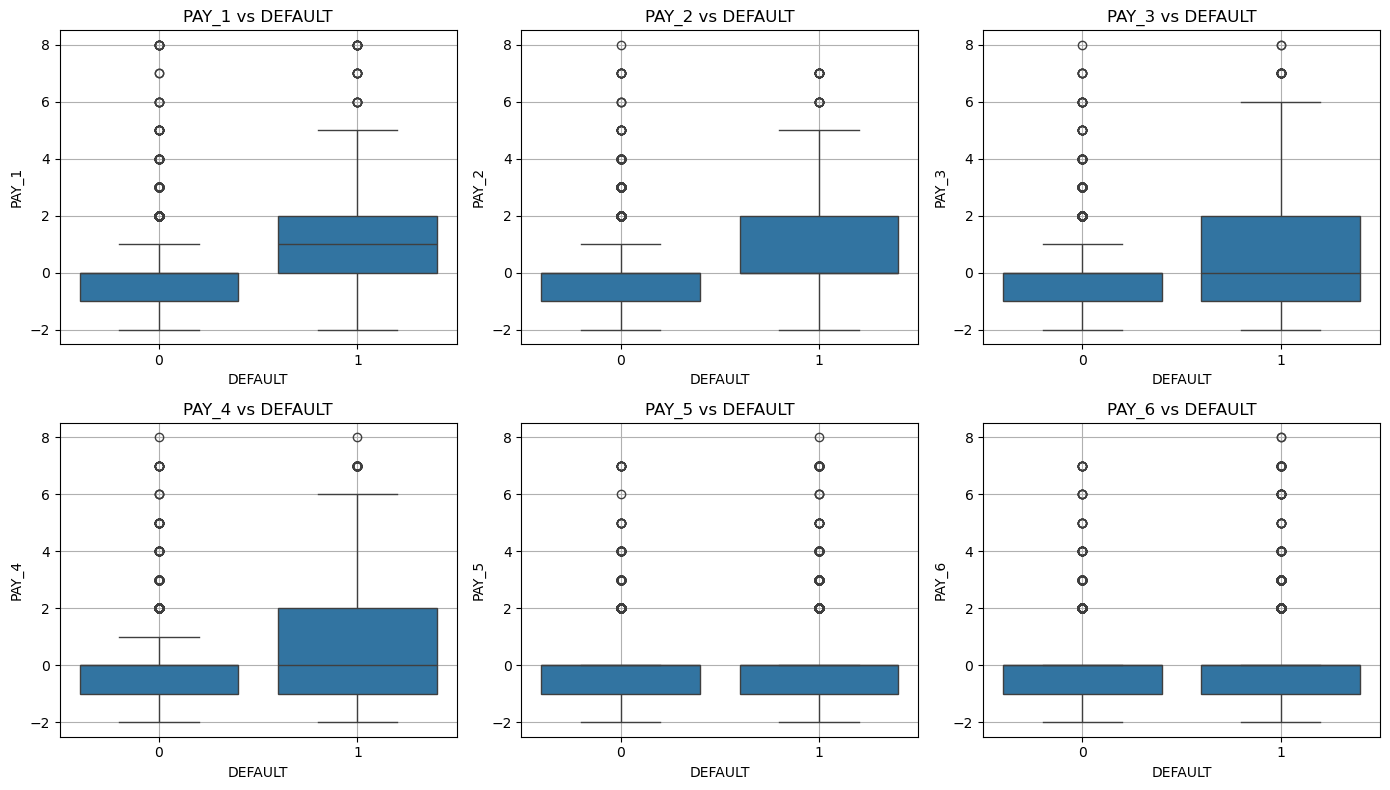

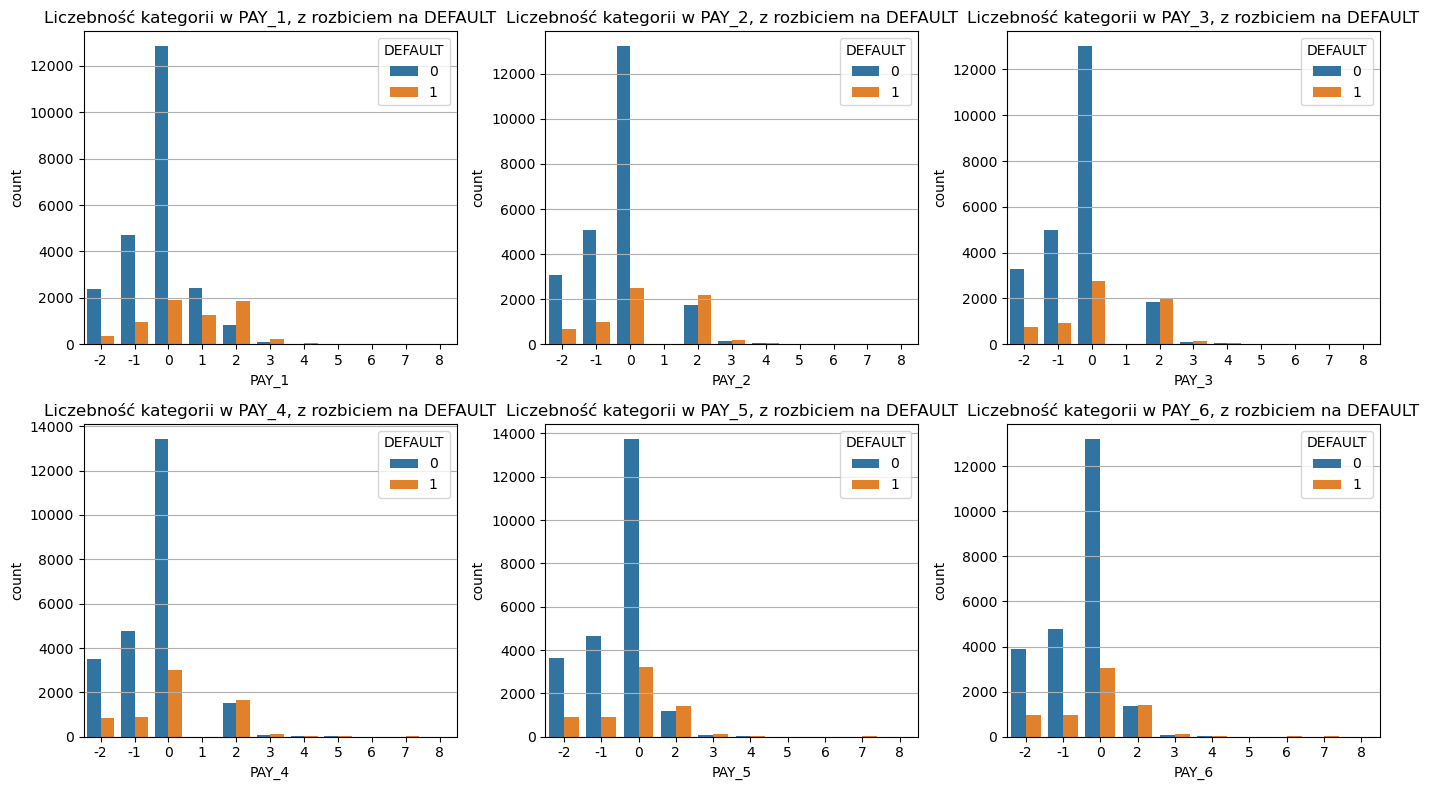

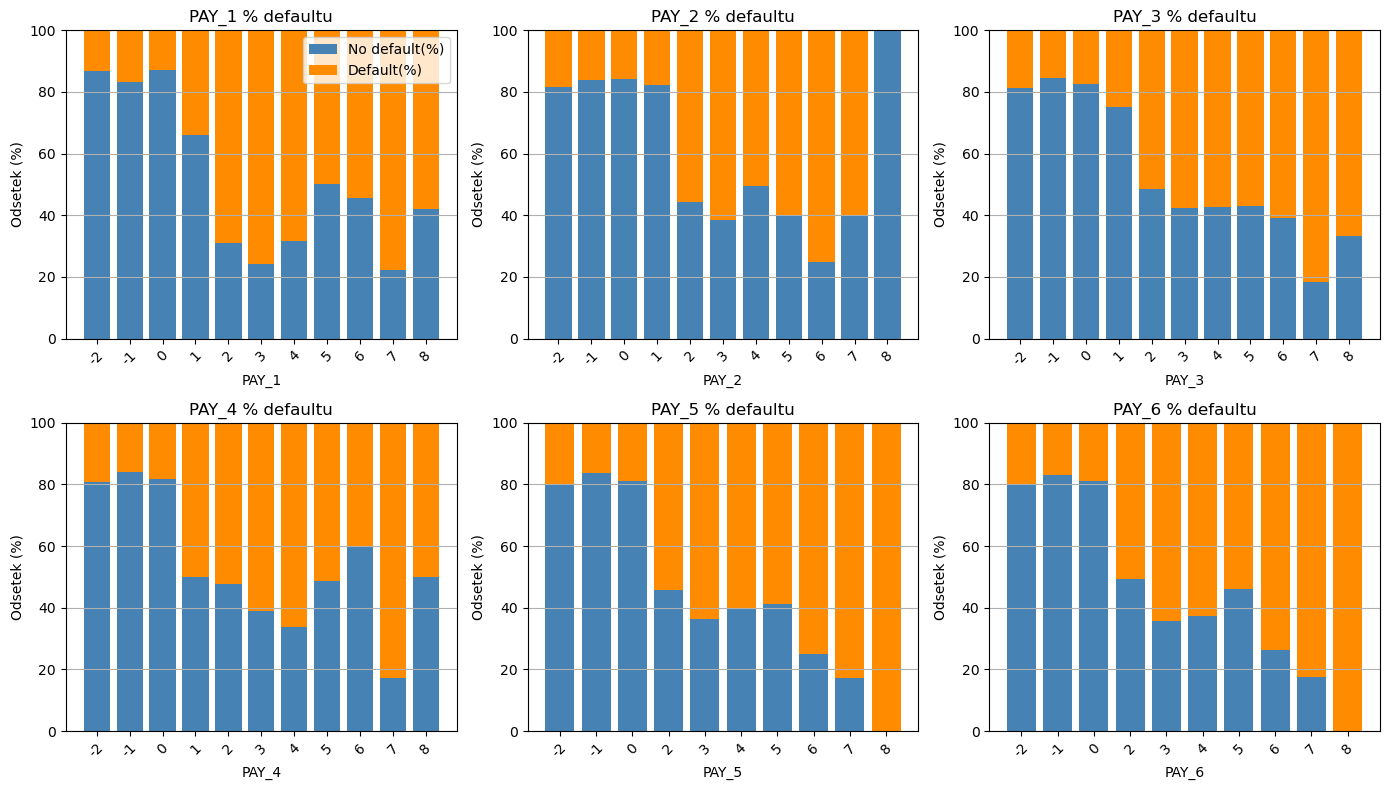

PAY_1: 65 obserwacji (ok. 0.22%) z wartością >= 5
PAY_2: 58 obserwacji (ok. 0.19%) z wartością >= 5
PAY_3: 74 obserwacji (ok. 0.25%) z wartością >= 5
PAY_4: 100 obserwacji (ok. 0.33%) z wartością >= 5
PAY_5: 80 obserwacji (ok. 0.27%) z wartością >= 5
PAY_6: 80 obserwacji (ok. 0.27%) z wartością >= 5


In [21]:
boxplot_pay_vars(df, pay_cols, 'DEFAULT')
count_pay_vars(df, pay_cols, 'DEFAULT')
stacked_bar_for_paycols(df, pay_cols, target='DEFAULT')
for col in pay_cols:
    n_outliers = (df[col] >= 5).sum()
    perc = n_outliers / len(df) * 100
    print(f"{col}: {n_outliers} obserwacji (ok. {perc:.2f}%) z wartością >= 5")

Zarówno boxploty, jak i countploty potwierdzają, że większość klientów ma status -2, -1 lub 0 (brak realnego opóźnienia), a w tej grupie odsetek defaultów jest relatywnie niewielki. Z kolei kategorie ≥1 sygnalizują większe ryzyko. Opóźnienia powyżej czterech miesięcy to tylko około 1,5% obserwacji, ale wśród niej proporcja defaultów jest wyraźnie wyższa, co jest trendem dla wszystkich obserwacji z zadłużeniem powyżej 2 miesięcy. Oznacza to, że choć opóźnienia na dużą skalę występują rzadko, to bardzo mocno korelują z niespłacaniem zadłużenia.

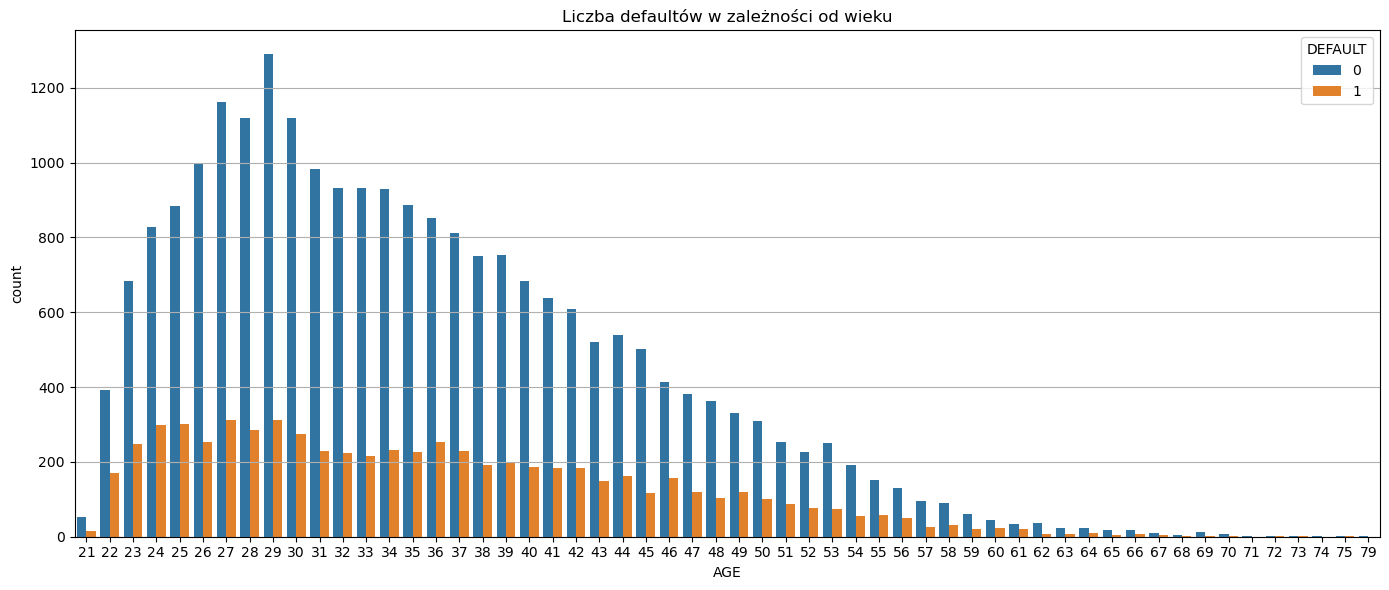

In [22]:
plt.figure(figsize=(14, 6))

sns.countplot(x='AGE', data=df, hue='DEFAULT')
plt.title('Liczba defaultów w zależności od wieku')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

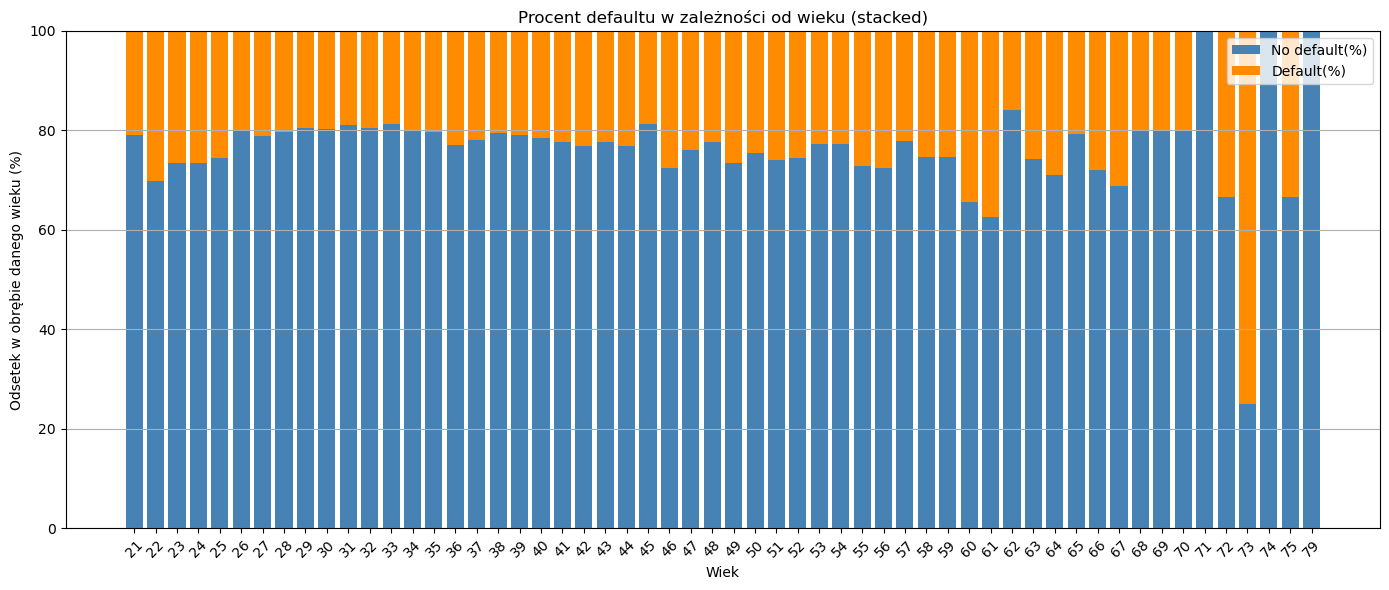

In [23]:
df_age = df.groupby(['AGE', 'DEFAULT']).size().reset_index(name='count')
df_age['total_by_age'] = df_age.groupby('AGE')['count'].transform('sum')
df_age['percentage'] = (df_age['count'] / df_age['total_by_age']) * 100
df_pivot = df_age.pivot(index='AGE', columns='DEFAULT', values='percentage').fillna(0)

ages = df_pivot.index
x = np.arange(len(ages))

vals_no_default = df_pivot[0]
vals_default = df_pivot[1]

plt.figure(figsize=(14, 6))
plt.bar(x, vals_no_default, label='No default(%)', color='steelblue')
plt.bar(x, vals_default, bottom=vals_no_default, label='Default(%)', color='darkorange')
plt.title('Procent defaultu w zależności od wieku (stacked)')
plt.xlabel('Wiek')
plt.ylabel('Odsetek w obrębie danego wieku (%)')
plt.xticks(x, ages, rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

Największa liczba klientów ma 25-35 lat, a ich procent defaultu jest niższy niż w innych grupach wiekowych. Dla klientów 60+ skala % może nie być miarodajna z uwagi na małą ilość danych w tym przedziale.

In [24]:
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

def scatter_six_plots(df, x_col, y_cols, hue_col='DEFAULT'):

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
    axes = axes.ravel()

    for i, col in enumerate(y_cols):
        ax = axes[i]
        sns.scatterplot(
            data=df,
            x=x_col,
            y=col,
            hue=hue_col,
            palette=['cornflowerblue', 'tomato'],
            alpha=0.5,
            ax=ax)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(style='plain')
        ax.set_title(f"{x_col} vs {col}")
        ax.grid(True)
        
        if i != 0:
            ax.get_legend().remove()
            
        
        
    plt.tight_layout()
    plt.show()

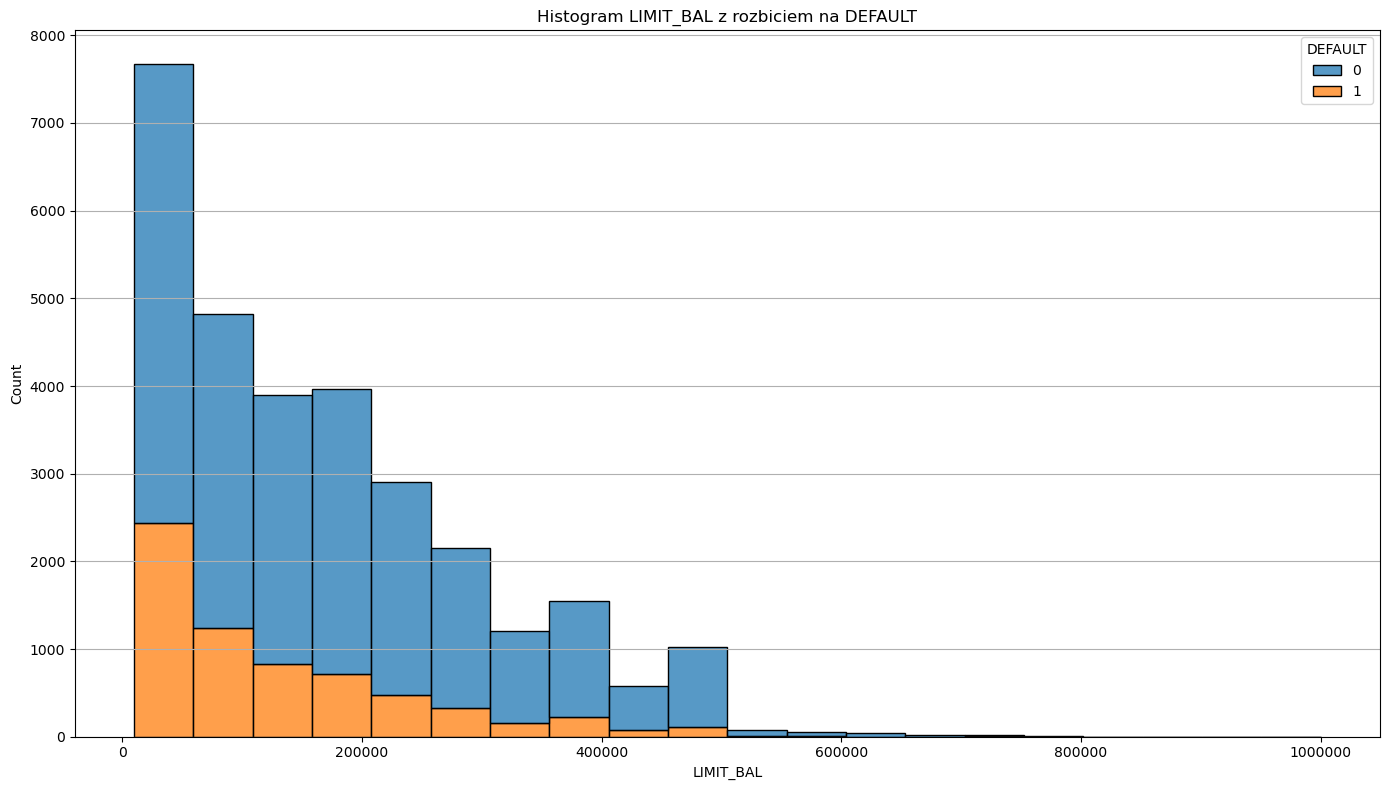

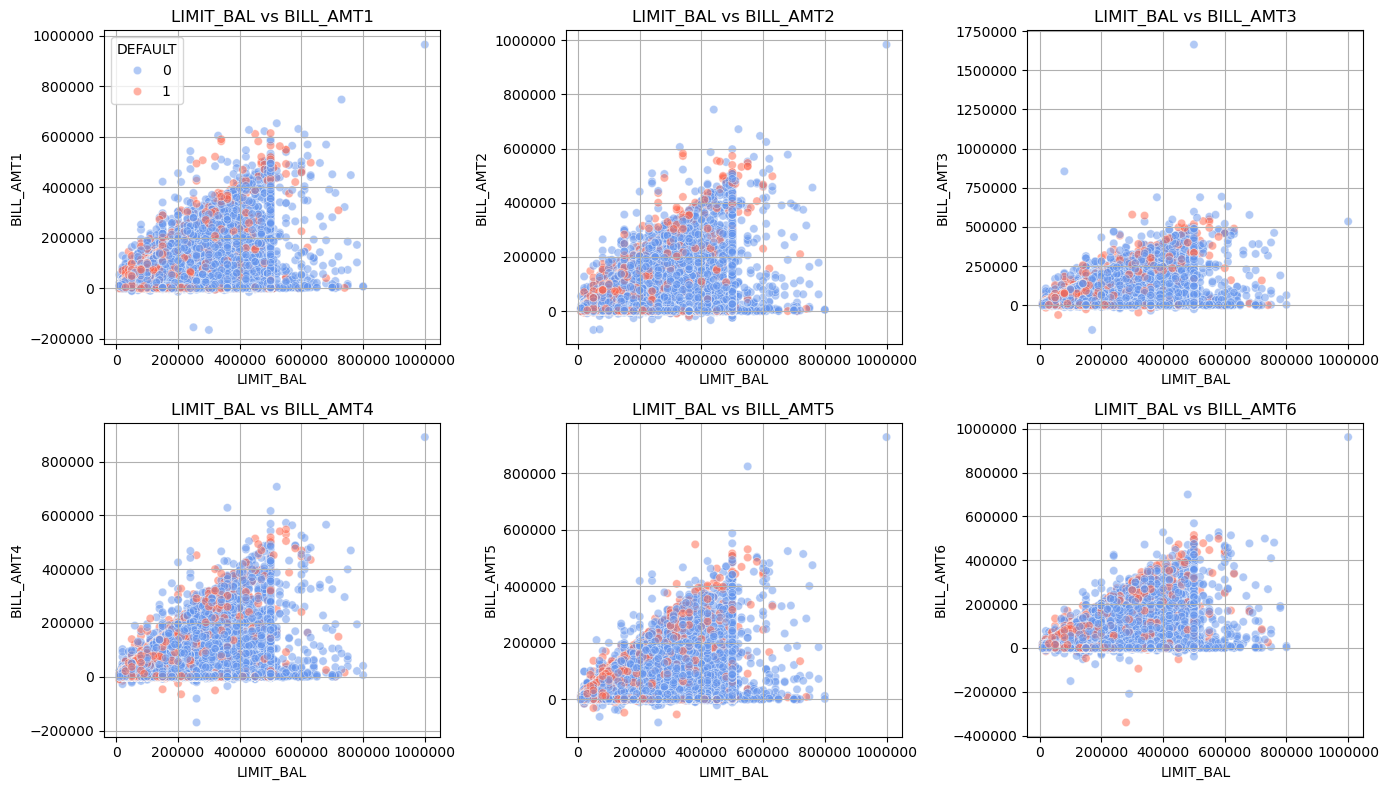

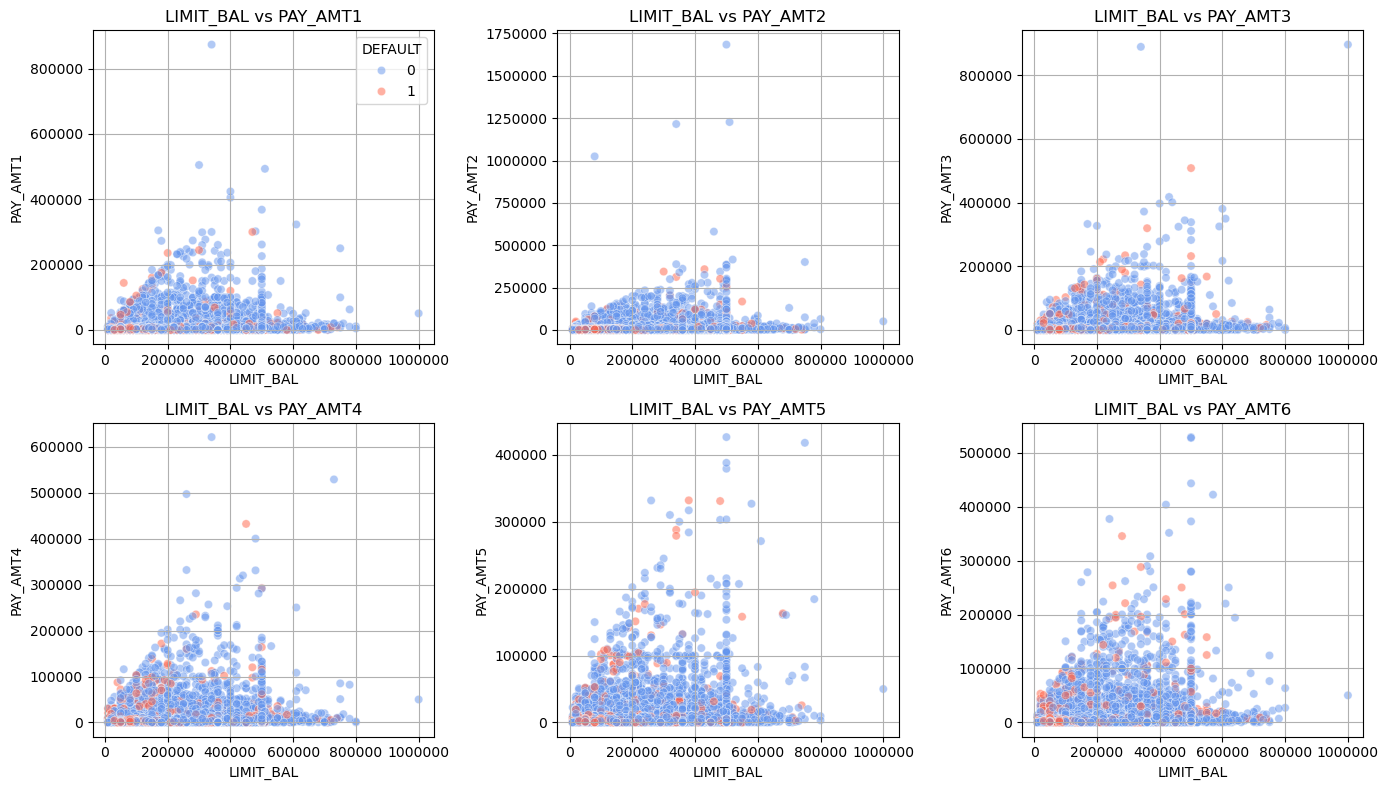

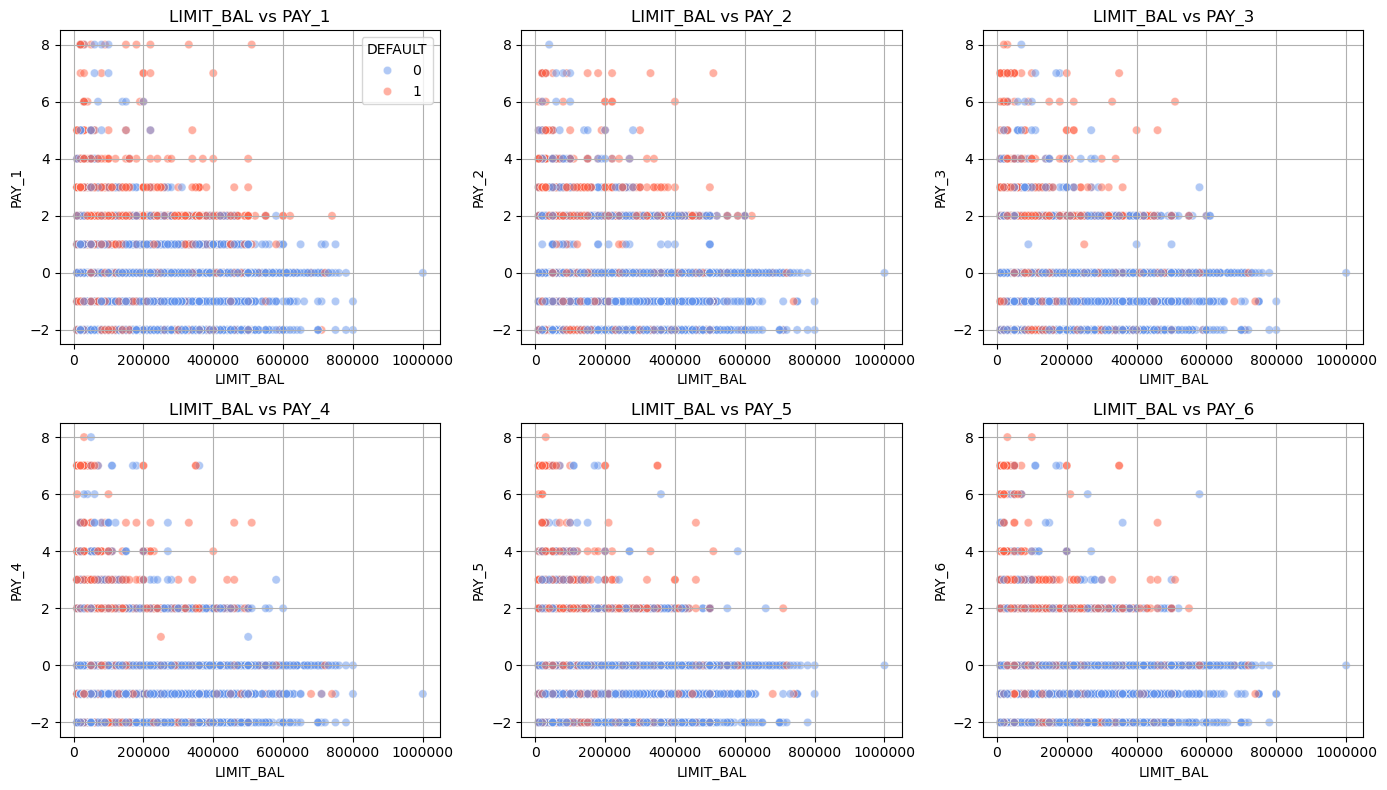

In [25]:
plt.figure(figsize=(14, 8))
ax = sns.histplot(
    data=df, 
    x="LIMIT_BAL",
    hue="DEFAULT",
    bins=20,
    multiple="stack")
plt.title("Histogram LIMIT_BAL z rozbiciem na DEFAULT")

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

scatter_six_plots(df, x_col='LIMIT_BAL', y_cols=bill_amt_cols)
scatter_six_plots(df, x_col='LIMIT_BAL', y_cols=pay_amt_cols)
scatter_six_plots(df, x_col='LIMIT_BAL', y_cols=pay_cols)

Wyższy `LIMIT_BAL` wiąże się z wyższymi wartościami `BILL_AMT` i `PAY_AMT`, co jest zrozumiałe. Punkty `DEFAULT` rozkładają się podobnie, więc nie widać silnej separacji - jedynie ogólna tendencja: wyższe limity to wyższe kwoty.

Klienci z niskim `LIMIT_BAL` mają większą tendencję do opóźnienia w spłatach.

### 4. Sprawdzenie możliwych nieścisłości

In [26]:
no_debt_default = df.query('BILL_AMT1 <= 0 and DEFAULT == 1').loc[:,('BILL_AMT1','LIMIT_BAL', 'PAY_AMT1', 'PAY_1')].sort_values(by='PAY_1', ascending=True)
no_debt_default

,BILL_AMT1,LIMIT_BAL,PAY_AMT1,PAY_1
23141,0,20000,0,-2
23092,0,470000,0,-2
7506,0,360000,0,-2
7515,0,340000,780,-2
23090,0,240000,0,-2
...,...,...,...,...
9628,0,150000,0,1
9791,0,200000,0,1
9826,0,280000,5072,1
10740,-3,360000,0,1


In [27]:
len(no_debt_default.query('PAY_1 > 1'))

0

Brak długu, a jednocześnie `DEFAULT` = 1 daje wrażenie sprzeczności, jednakże brak dokładnej definicji `DEFAULT`, wskazuje na możliwość, że w kolejnym terminie rozliczeniowym, mimo wcześniejszego braku zobowiązań klient stał się dłużnikiem. Spójność danych potwierdza również sprawdzenie czy w `PAY_1` występują wartości powyżej 1. Nie ma ich więc dane wydają się być rzetelne.

In [28]:
overlimit = df.query('BILL_AMT1 > LIMIT_BAL').loc[:,('BILL_AMT1','LIMIT_BAL', 'PAY_AMT1', 'PAY_1', 'DEFAULT')].sort_values(by='PAY_1', ascending=True)
overlimit

,BILL_AMT1,LIMIT_BAL,PAY_AMT1,PAY_1,DEFAULT
5947,91272,90000,5000,-2,0
16137,51741,50000,300,-2,1
21678,50096,50000,1000,-2,0
12842,194843,80000,5501,-2,0
9379,20732,20000,2,-2,1
...,...,...,...,...,...
11554,161569,150000,0,8,1
9979,35031,30000,0,8,1
981,34423,30000,0,8,0
13261,69183,60000,0,8,0


In [29]:
len(overlimit.query('PAY_1 < 0')) / len(overlimit) * 100

2.127659574468085

In [30]:
len(overlimit.query('PAY_1 == 0')) / len(overlimit) * 100

63.593380614657214

In [31]:
len(overlimit.query('DEFAULT == 1')) / len(overlimit) * 100

30.070921985815602

Przekroczenie limitu samo w sobie niekoniecznie musi być błędem. Nawet jeśli klient spłacił nadwyżkowe zadłużenie (`PAY_AMOUNT1`) to mógł nabyć dodatkowy dług przed zamknięciem tego okresu rozliczeniowego. Większość z tych osób ma również wartość `PAY_1` = 0 (ponad 63%) czyli użyło kredytu odnawialnego, a tylko 2% wcześniej terminowo regulowała spłaty, co potwierdza hipotezę o prawdopodobnym nabyciu odsetek, które sprawiły, że limit został przekroczony. Ponad 30% z tej grupy ma flagę `DEFAULT`, jest to więc grupa podwyższonego ryzyka.

### 5. Wartości odstające 

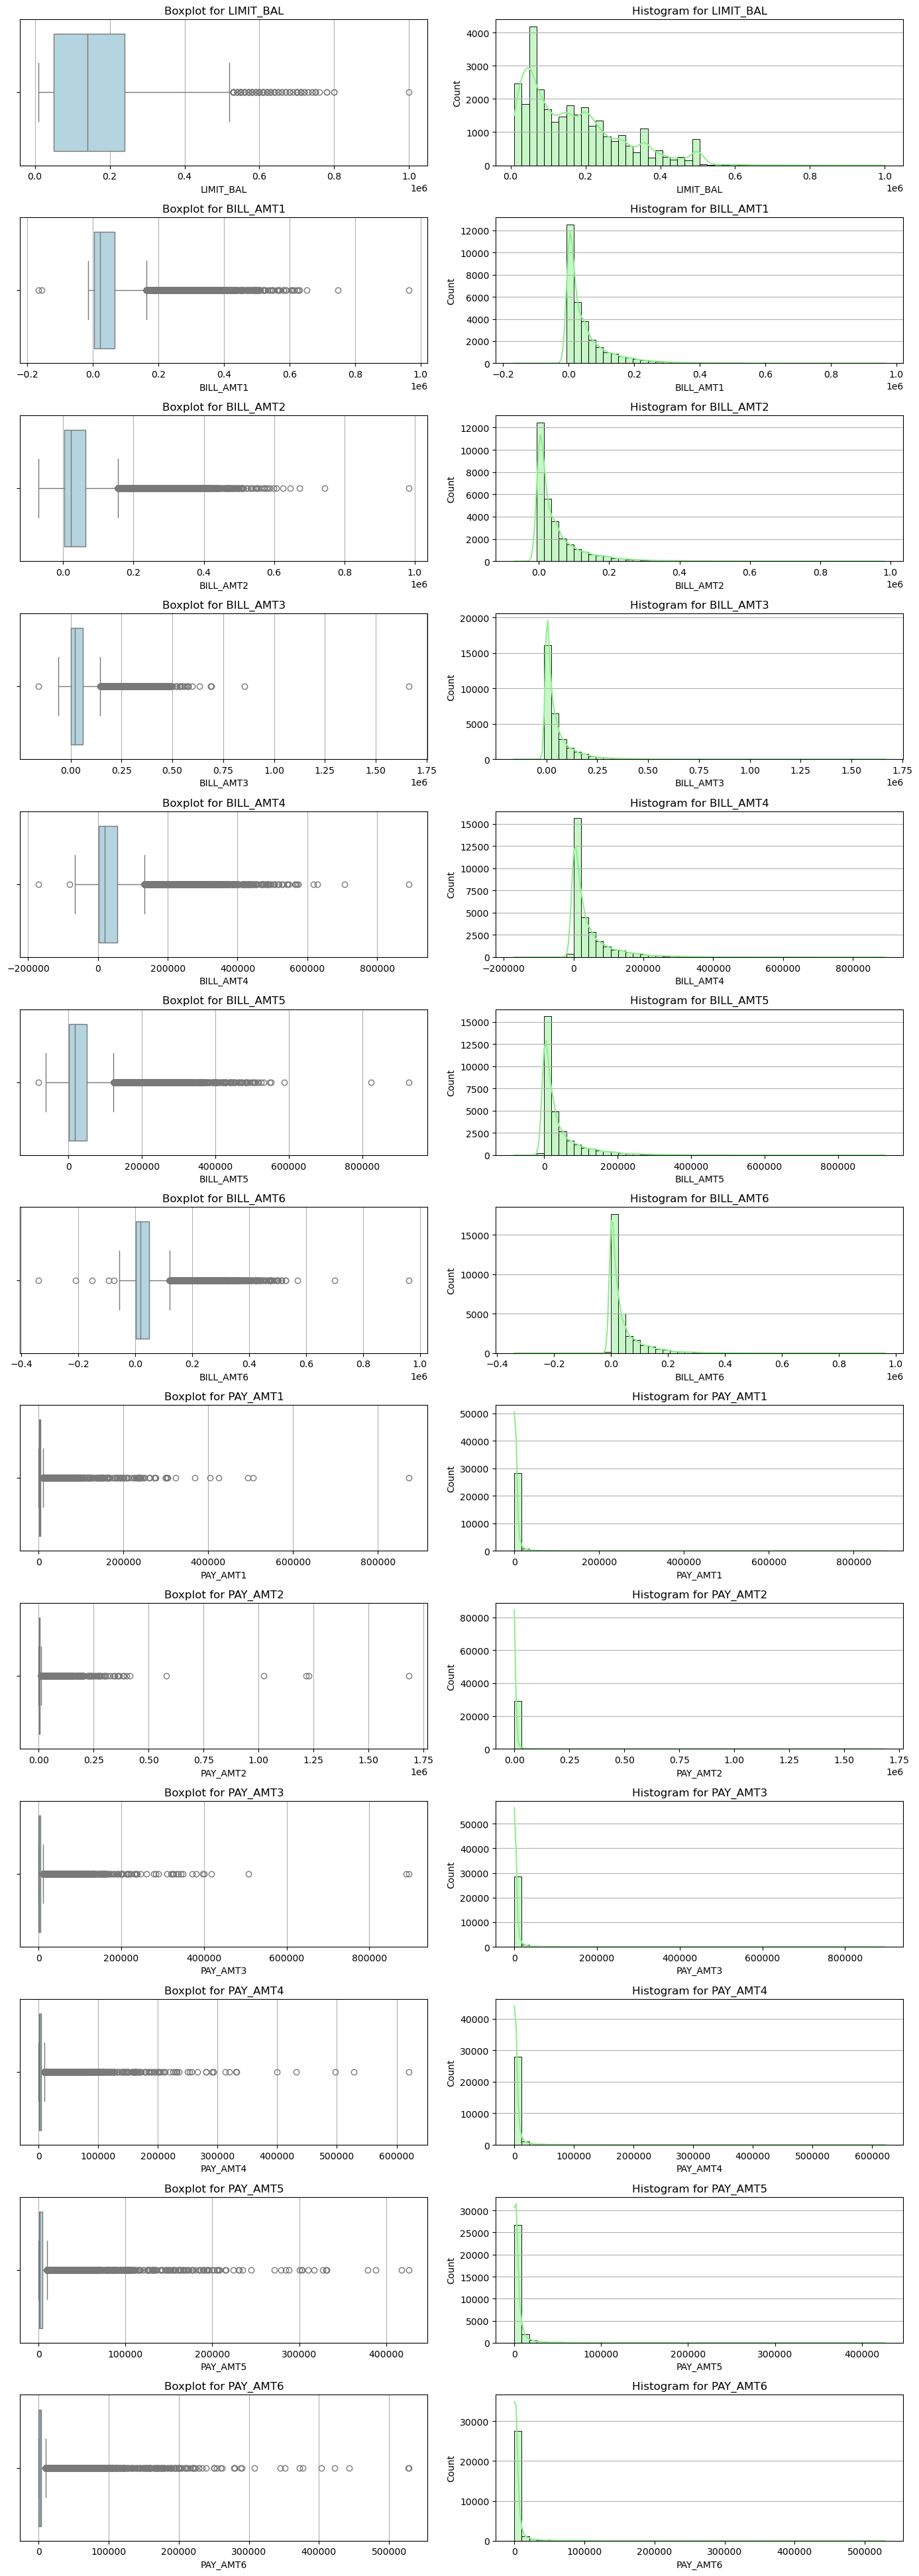

In [32]:
continuous_vars = ['LIMIT_BAL'] + bill_amt_cols + pay_amt_cols

fig, axes = plt.subplots(nrows=len(continuous_vars), ncols=2, figsize=(14, 3*len(continuous_vars)))

for i, var in enumerate(continuous_vars):
    # Wykres pudełkowy
    sns.boxplot(data=df, x=var, ax=axes[i, 0], color='lightblue')
    axes[i, 0].set_title(f"Boxplot for {var}")
    axes[i, 0].grid(True, axis='x')

    # Histogram
    sns.histplot(data=df, x=var, ax=axes[i, 1], kde=True, color='lightgreen', bins=50)
    axes[i, 1].set_title(f"Histogram for {var}")
    axes[i, 1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [33]:
def detect_outliers_iqr(df, col, k=1.5):
    """
    Zwraca indeksy obserwacji uznanych za outliery w kolumnie 'col'
    w oparciu o regułę IQR i parametr k (domyślnie 1.5).
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    # Zwracamy tu boolean maskę
    outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outliers_mask

def summarize_outliers(df, continuous_cols, k=1.5):
    outlier_info = {}
    
    for c in continuous_cols:
        mask = detect_outliers_iqr(df, c, k)
        n_outliers = mask.sum()
        perc_outliers = round((n_outliers / len(df)) * 100, 2)
        outlier_info[c] = (n_outliers, perc_outliers)
    
    return outlier_info

continuous_vars = ['LIMIT_BAL'] + bill_amt_cols + pay_amt_cols
outliers_summary = summarize_outliers(df, continuous_vars, k=1.5)

for col, (count_outl, perc_outl) in outliers_summary.items():
    print(f"{col}: {count_outl} outliers, stanowią {perc_outl}% wszystkich obserwacji.")

LIMIT_BAL: 167 outliers, stanowią 0.56% wszystkich obserwacji.
BILL_AMT1: 2386 outliers, stanowią 7.96% wszystkich obserwacji.
BILL_AMT2: 2390 outliers, stanowią 7.98% wszystkich obserwacji.
BILL_AMT3: 2469 outliers, stanowią 8.24% wszystkich obserwacji.
BILL_AMT4: 2616 outliers, stanowią 8.73% wszystkich obserwacji.
BILL_AMT5: 2724 outliers, stanowią 9.09% wszystkich obserwacji.
BILL_AMT6: 2688 outliers, stanowią 8.97% wszystkich obserwacji.
PAY_AMT1: 2742 outliers, stanowią 9.15% wszystkich obserwacji.
PAY_AMT2: 2723 outliers, stanowią 9.09% wszystkich obserwacji.
PAY_AMT3: 2596 outliers, stanowią 8.66% wszystkich obserwacji.
PAY_AMT4: 2993 outliers, stanowią 9.99% wszystkich obserwacji.
PAY_AMT5: 2944 outliers, stanowią 9.82% wszystkich obserwacji.
PAY_AMT6: 2960 outliers, stanowią 9.88% wszystkich obserwacji.


In [34]:
mask_k3 = detect_outliers_iqr(df, 'LIMIT_BAL', k=3)

# Zobacz, ile takich obserwacji:
print(mask_k3.sum())

# Wyciągnij je w formie DataFrame:
outliers_lb_k3 = df[mask_k3]
display(outliers_lb_k3)

1


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
2197,1000000,2,1,1,47,0,0,0,-1,0,...,891586,927171,961664,50784,50723,896040,50000,50000,50256,0


W danych jest sporo outlierów, ale wydają się to być po prostu konta bogatych klientów, których naturalnie jest mniej. Nawet najbardziej ekstremalny przypadek to po prostu przykład możliwego klienta VIP. Logarytmizacja tych danych, zredukuje "ogony", co może wspomóc uczenie modelu.

### Inżynieria cech

In [35]:
from sklearn.preprocessing import PowerTransformer

class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer, który stosuje metodę Yeo-Johnson
    do wybranych kolumn (mających wartości ujemne / dodatnie).
    """
    def __init__(self, cols):
        # cols = lista kolumn, które chcemy przetransformować
        self.cols = cols
        self.yj = PowerTransformer(method='yeo-johnson')
        
    def fit(self, X, y=None):
        
        subset = X[self.cols]
        
        # Dopasowujemy parametry Yeo-Johnsona
        self.yj.fit(subset)
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        
        subset = X_[self.cols]
       
        subset_transformed = self.yj.transform(subset)
        
        subset_transformed = pd.DataFrame(
            subset_transformed,
            columns=self.cols,
            index=X_.index
        )
        
        for c in self.cols:
            X_[c] = subset_transformed[c]
        return X_

In [36]:
class BinarySex(BaseEstimator, TransformerMixin):
    """
    Transformer, który zamienia wartości 1/2 w kolumnie `SEX` na 0/1.
    Domyślnie oczekuje kolumny 'SEX' z wartościami {1,2}.
    """
    def __init__(self, col='SEX'):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        mapping_dict = {1: 0, 2: 1}
        X_[self.col] = X_[self.col].map(mapping_dict)
        return X_

In [37]:
class MarriageSimplifier(BaseEstimator, TransformerMixin):
    """
    Z kolumny MARRIAGE (1 - married, 2 - single, 3 - others)
    tworzy dwie kolumny binarne: MARRIED, SINGLE.
    Obserwacje 'others' będą (MARRIED=0, SINGLE=0).
    """
    def __init__(self, col='MARRIAGE'):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['MARRIED'] = (X_[self.col] == 1).astype(int)
        X_['SINGLE']  = (X_[self.col] == 2).astype(int)
        
        # Usuwamy oryginalną kolumnę
        X_.drop(columns=[self.col], inplace=True)
        
        return X_

In [38]:
class EducationOneHot(BaseEstimator, TransformerMixin):
    """
    Zamienia kolumnę EDUCATION na kody 0/1 w postaci EDUCATION_x,
    przy czym kategoria najwyższa (np. 4 = 'others') jest 
    traktowana jako referencyjna i nie powstaje dla niej kolumna.

    Jeśli w danych są kategorie [1,2,3,4], posortowane rosnąco,
    to tworzymy trzy kolumny: EDUCATION_1, EDUCATION_2, EDUCATION_3.
    Dla wiersza, który ma EDUCATION=4 (others), wszystkie
    powyższe kolumny będą miały 0 (referencja).
    """
    def __init__(self, col='EDUCATION'):
        self.col = col

    def fit(self, X, y=None):
        X_ = X.copy()
        # Sortujemy unikatowe wartości, np. [1,2,3,4].
        self.categories_ = sorted(X_[self.col].unique())
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        # Tworzymy kolumny one-hot dla wszystkich kategorii
        # oprócz OSTATNIEJ, którą traktujemy jako referencję (drop).
        for cat in self.categories_[:-1]:
            new_col_name = f"{self.col}_{cat}"
            X_[new_col_name] = (X_[self.col] == cat).astype(int)

        # Usuwamy oryginalną kolumnę
        X_.drop(columns=[self.col], inplace=True)
        return X_

In [39]:
class PayScoreAggregator(BaseEstimator, TransformerMixin):
    """
    Transformer do wyliczania kluczowych cech z historii opóźnień (PAY_*).

    Parametry:
    ----------
    pay_cols : list of str
        Lista nazw kolumn, np. ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'].
        Zawierają status opóźnienia w spłacie dla każdego miesiąca:
        - wartości ujemne (np. -2, -1) oznaczają brak realnego opóźnienia,
        - wartości dodatnie (1, 2, 3...) oznaczają liczbę miesięcy zaległości.

    Wyliczane cechy:
    ---------------
    PAY_MEAN : float
        Średnia arytmetyczna z opóźnień (pay_cols).
    PAY_MAX : float
        Maksymalny poziom opóźnienia w ostatnich 6 miesiącach.
    PAY_COUNT_DELAYED : int
        Liczba miesięcy, w których wystąpiło opóźnienie > 0.
    PAY_COUNT_NO_DELAY : int
        Liczba miesięcy, w których status opóźnienia < 0 (brak zadłużenia).
    PAY_INCREASING_COUNT : int
        Dla każdej pary kolejnych miesięcy (i, i+1) sprawdza, czy opóźnienie
        w (i+1) jest wyższe niż w i oraz czy (i+1) > 0. Sumuje takie przypadki.
        Daje informację, ile razy opóźnienie wzrastało pomiędzy sąsiednimi miesiącami.

    """
    def __init__(self, pay_cols):
        self.pay_cols = pay_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        
        # Średnia (ze wszystkich pay_cols)
        X_['PAY_MEAN'] = X_[self.pay_cols].mean(axis=1)
        
        # Max opóźnienie
        X_['PAY_MAX'] = X_[self.pay_cols].max(axis=1)
        
        # Liczba miesięcy z długiem
        X_['PAY_COUNT_DELAYED'] = (X_[self.pay_cols] > 0).sum(axis=1)
        
        # Liczba miesięcy z brakiem opóźnienia
        X_['PAY_COUNT_NO_DELAY'] = (X_[self.pay_cols] < 0).sum(axis=1)


        return X_

In [40]:
class PayAggregator(BaseEstimator, TransformerMixin):
    """
    Transformer do wyliczania cech związanych z zadłużeniem (BILL_AMT*),
    spłatą (PAY_AMT*) oraz limitem kredytowym (LIMIT_BAL).

    Logika 'ratio':
    ---------------
    - Ujemne wartości w bill i pay clampujemy do 0.
    - Jeśli w danym miesiącu powstaje bill=0 i pay=0, ratio=1 (wszystko spłacone, bo nic nie było do spłaty).
    - W pozostałych przypadkach ratio = pay / (bill + 1e-9).
    - ratio ograniczamy clip(upper=10), interpretując wszystko >10 jako bardzo duża nadpłata.
    - Domyślnie, jeśli jeszcze jest NaN, zamieniamy je na 1.

    Wyliczane kolumny (przykładowe):
    --------------------------------
    - DEBT_RATIO_CURRENT, DEBT_RATIO_MEAN, DEBT_RATIO_MAX
    - RATIO_PAY_1.. RATIO_PAY_6
    - PAY_RATIO_MEAN, PAY_RATIO_COUNT_BELOW_1
    - OVER_LIMIT, OVER_LIMIT_COUNT
    """
    def __init__(self, pay_amt_cols, bill_amt_cols, limit_col, pay_cols):
        self.pay_amt_cols = pay_amt_cols
        self.bill_amt_cols = bill_amt_cols
        self.limit_col = limit_col
        self.pay_cols = pay_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        
        # Wskaźnik aktualnego zadłużenia
        X_['DEBT_RATIO_CURRENT'] = X_[self.bill_amt_cols[0]] / X_[self.limit_col]
        
        # Wskaźnik średniego zadłużenia
        X_['DEBT_RATIO_MEAN'] = X_[self.bill_amt_cols].mean(axis=1) / X_[self.limit_col]

        # Wskaźnik maksymalnego zadłużenia
        X_['DEBT_RATIO_MAX'] = X_[self.bill_amt_cols].max(axis=1) / X_[self.limit_col]

        # Wskaźniki spłaty
        ratio_cols = []
        for i in range(len(self.pay_amt_cols)):
            ratio_col = f'RATIO_PAY_{i+1}'
            bill_series = X_[self.bill_amt_cols[i]].clip(lower=0)
            pay_series  = X_[self.pay_amt_cols[i]].clip(lower=0)

            ratio = pay_series / (bill_series + 1e-9)

            mask_both_zero = (bill_series == 0) & (pay_series == 0)
            ratio[mask_both_zero] = 1

            ratio = ratio.clip(0, 10)
            X_[ratio_col] = ratio
            ratio_cols.append(ratio_col)

        X_['PAY_RATIO_MEAN'] = X_[ratio_cols].mean(axis=1)
        X_['PAY_RATIO_COUNT_BELOW_1'] = (X_[ratio_cols] < 1).sum(axis=1)

        # Przekroczenie limitu
        X_['OVER_LIMIT'] = (X_[self.bill_amt_cols[0]] > X_[self.limit_col]).astype(int)

        X_['OVER_LIMIT_COUNT'] = sum((X_[self.bill_amt_cols[i]] > X_[self.limit_col]).astype(int) for i in range(len(self.bill_amt_cols)))
        return X_

In [41]:
class PayTrends(BaseEstimator, TransformerMixin):
    """
    Transformer do wyliczania trendów w opóźnieniach (PAY_*).

    Wyliczane cechy:
    ---------------
    - PAY_TREND_1_2, PAY_TREND_2_3, ..., PAY_TREND_5_6:
        Dla każdej pary kolejnych miesięcy (i, i+1) sprawdza, czy opóźnienie
        w (i+1) jest wyższe niż w i oraz czy (i+1) > 0. Sumuje takie przypadki.
        Daje informację, ile razy opóźnienie wzrastało pomiędzy sąsiednimi miesiącami.
    """
    def __init__(self, pay_cols, pay_amt_cols, bill_amt_cols):
        self.pay_cols = pay_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()

        delays = X_[self.pay_cols].values
        delays_number = []

        # Licznik opóźnień
        for row in delays:
            count_increasing = 0
            for i in range(len(self.pay_cols) - 1):
                if row[i] > row[i + 1] and row[i] > 0:
                    count_increasing += 1
            delays_number.append(count_increasing)

        X_['PAY_INC_TREND'] = delays_number

        # Zmiana kwoty zadłużenia
        bill_amt = X_[bill_amt_cols].values
        bill_diff_list = []

        # Tworzenie kolumn różnic i zbieranie ich do listy
        for i in range(len(bill_amt_cols) - 1):
            col_name = f"BILL_AMT_DIFF_{i+1}_{i+2}"
            diff_values = bill_amt[:, i] - bill_amt[:, i+1]
            X_[col_name] = diff_values
            bill_diff_list.append(diff_values.reshape(-1, 1))

        bill_diff_matrix = np.hstack(bill_diff_list)

        # 3) Liczymy sumy przyrostów i spadków wzdłuż wiersza (axis=1)
        X_["BILL_AMT_INC_SUM"] = np.where(bill_diff_matrix>0, bill_diff_matrix, 0).sum(axis=1)
        X_["BILL_AMT_DECR_SUM"] = np.where(bill_diff_matrix<0, bill_diff_matrix, 0).sum(axis=1)

        #Zmiana kwoty spłaty
        pay_amt = X_[pay_amt_cols].values
        amt_diff_list = []

        for i in range(len(pay_amt_cols) - 1):
            col_name = f"PAY_AMT_DIFF_{i+1}_{i+2}"
            diff_values = pay_amt[:, i] - pay_amt[:, i+1]
            X_[col_name] = diff_values
            amt_diff_list.append(diff_values.reshape(-1, 1))

        amt_diff_matrix = np.hstack(amt_diff_list)

        X_["PAY_AMT_INC_SUM"] = np.where(amt_diff_matrix>0, amt_diff_matrix, 0).sum(axis=1)
        X_["PAY_AMT_DECR_SUM"] = np.where(amt_diff_matrix<0, amt_diff_matrix, 0).sum(axis=1)
                
        return X_

In [45]:
class InteractionTransformer(BaseEstimator, TransformerMixin):
    """
    Tworzy kolumny będące iloczynami wybranych par cech.

    Parametry:
    ----------
    interaction_pairs : list of tuples
        Lista krotek (col1, col2, new_col_name), np.
        [
            ("PAY_MAX", "DEBT_RATIO_CURRENT", "PAY_MAX_x_DEBT_RATIO_CURRENT"),
            ("PAY_COUNT_DELAYED", "OVER_LIMIT_COUNT", "DELAYED_x_OVERLIMIT")
        ]
    """
    def __init__(self, interaction_pairs):
        self.interaction_pairs = interaction_pairs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        for (col1, col2, new_col) in self.interaction_pairs:
            X_[new_col] = X_[col1] * X_[col2]
        return X_
    
interaction_pairs = [
    ("PAY_MAX", "DEBT_RATIO_CURRENT", "PAY_MAX_x_DEBT_RATIO_CURRENT"),
    ("PAY_COUNT_DELAYED", "OVER_LIMIT_COUNT", "DELAYED_x_OVERLIMIT_COUNT"),
    ("PAY_INC_TREND", "OVER_LIMIT_COUNT", "PAY_INC_TREND_x_OVERLIMIT_COUNT"),
    ("BILL_AMT_INC_SUM", "PAY_AMT_INC_SUM", "BILL_INC_SUM_x_PAY_INC_SUM"),
    ("PAY_RATIO_MEAN", "PAY_MAX", "PAY_RATIO_MEAN_x_PAY_MAX"),
    ("PAY_COUNT_NO_DELAY", "PAY_AMT_INC_SUM", "NO_DELAY_x_PAY_INC_SUM")
]

In [46]:
class AutoYeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    """
    Samoczynnie wyszukuje kolumny numeryczne, 
    odfiltrowuje binarne / wykluczone i aplikuje Yeo-Johnson.
    """

    def __init__(self, 
                 skip_cols=None,
                 max_unique_for_skip=2,
                 method='yeo-johnson'):
        """
        skip_cols : list 
            Lista kolumn, które na pewno chcesz pominąć w transformacji
            (np. PAY_*, AGE, kolumny kategoryczne zakodowane 0/1, itp.).
        max_unique_for_skip : int
            Jeśli kolumna ma liczbę unikalnych wartości <= max_unique_for_skip,
            traktujemy ją jako binarną / niepotrzebną do Yeo-Johnson i pomijamy.
        method : 'yeo-johnson' lub 'box-cox'
            Parametr do PowerTransformer.
        """
        self.skip_cols = skip_cols if skip_cols else []
        self.max_unique_for_skip = max_unique_for_skip
        self.method = method

    def fit(self, X, y=None):
        X_ = X.copy()

        # Znajdujemy kolumny numeryczne
        numeric_cols = X_.select_dtypes(include=[np.number]).columns.tolist()

        # Wykluczamy kolumny
        self.cols_ = []
        for col in numeric_cols:
            if col in self.skip_cols:
                continue
            if X_[col].nunique() <= self.max_unique_for_skip:
                continue
            self.cols_.append(col)

        # Dopasowujemy PowerTransformer do tych kolumn
        self.pt_ = PowerTransformer(method=self.method)
        self.pt_.fit(X_[self.cols_])

        return self

    def transform(self, X, y=None):
        X_ = X.copy()

        # Aplikujemy transformację kolumn
        if self.cols_:
            transformed = self.pt_.transform(X_[self.cols_])
            transformed_df = pd.DataFrame(transformed, 
                                          columns=self.cols_, 
                                          index=X_.index)
            for c in self.cols_:
                X_[c] = transformed_df[c]

        return X_
    
auto_yeo = AutoYeoJohnsonTransformer(
    skip_cols=["AGE"] + pay_cols,  # np. pomijasz kolumnę AGE i PAY_*
    max_unique_for_skip=2,        # binarne out
    method="yeo-johnson"
)

In [ ]:
pipeline = Pipeline([
    ('binarysex', BinarySex(col='SEX')),
    ('marriage_simplifier', MarriageSimplifier(col='MARRIAGE')),
    ('education_onehot', EducationOneHot(col='EDUCATION')),
    ('pay_score_aggregator', PayScoreAggregator(pay_cols=pay_cols)),
    ('pay_aggregator', PayAggregator(pay_amt_cols=pay_amt_cols, bill_amt_cols=bill_amt_cols, pay_cols=pay_cols, limit_col='LIMIT_BAL')),
    ('pay_trends', PayTrends(pay_cols=pay_cols, pay_amt_cols=pay_amt_cols, bill_amt_cols=bill_amt_cols)),
    ("interaction", InteractionTransformer(interaction_pairs)),
    ("auto_yeo", auto_yeo),
    #('yeojohnson', YeoJohnsonTransformer(cols=bill_amt_cols + pay_amt_cols + ['LIMIT_BAL'])),                                 
    # ... dalsze kroki ...
], memory=None)
df_transformed = pipeline.fit_transform(df)

In [58]:
df_transformed.head()


,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT_DIFF_4_5,PAY_AMT_DIFF_5_6,PAY_AMT_INC_SUM,PAY_AMT_DECR_SUM,PAY_MAX_x_DEBT_RATIO_CURRENT,DELAYED_x_OVERLIMIT_COUNT,PAY_INC_TREND_x_OVERLIMIT_COUNT,BILL_INC_SUM_x_PAY_INC_SUM,PAY_RATIO_MEAN_x_PAY_MAX,NO_DELAY_x_PAY_INC_SUM
0,-1.664977,1,24,2,2,-1,-1,-2,-2,-0.655612,...,0.004983,-0.001479,-0.779625,0.469991,0.428369,-0.249951,-0.227617,-0.448762,0.594056,0.961791
1,-0.089745,1,26,-1,2,0,0,0,2,-0.680121,...,0.053820,-0.089649,-0.636837,-0.077099,-0.284474,-0.249951,-0.227617,-0.601913,0.354790,0.819131
2,-0.396050,1,34,0,0,0,0,0,0,-0.240301,...,0.004983,-0.176766,-0.882827,-0.198680,-0.400609,-0.249951,-0.227617,-0.227758,0.030600,-0.821180
3,-0.953291,1,37,0,0,0,0,0,0,0.016303,...,0.006510,0.001836,-0.629372,1.390044,-0.400609,-0.249951,-0.227617,-0.010481,0.030600,-0.821180
4,-0.953291,0,57,-1,0,-1,0,0,0,-0.569266,...,0.408612,-0.001005,1.335659,-1.296302,-0.400609,-0.249951,-0.227617,0.999909,0.030600,1.316137


In [59]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 65 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   LIMIT_BAL                        29965 non-null  float64
 1   SEX                              29965 non-null  int64  
 2   AGE                              29965 non-null  int64  
 3   PAY_1                            29965 non-null  int64  
 4   PAY_2                            29965 non-null  int64  
 5   PAY_3                            29965 non-null  int64  
 6   PAY_4                            29965 non-null  int64  
 7   PAY_5                            29965 non-null  int64  
 8   PAY_6                            29965 non-null  int64  
 9   BILL_AMT1                        29965 non-null  float64
 10  BILL_AMT2                        29965 non-null  float64
 11  BILL_AMT3                        29965 non-null  float64
 12  BILL_AMT4              

### Podział dancyh na zestaw treningowy i testowy

In [ ]:
# Wyodrębnienie y (target) i X (features)
X = df.drop(columns=['DEFAULT'])
y = df['DEFAULT']

In [ ]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
